# Étape 3 : Approche non supervisée
- Objectifs :
    - • Proposer une solution unsupervised de suggestion de mots-clés/tags
- Sous-tâches :
    1. Extraction de features textuelles (TF-IDF, embeddings simples…)
    2. Clustering (KMeans, DBSCAN…) + analyse de cluster
    3. Déduction de tags par cluster (mots les plus représentatifs ? Co-occurrence ?)
    4. Évaluation avec un indicateur adapté (taux de couverture par exemple)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from yellowbrick.cluster import KElbowVisualizer

In [3]:
df = pd.read_csv('données_propre/donnees_propre.csv')
df.head(3)

,Title,Body,Tags,text,text_clean
0,How to convert Decimal to Double in C#?,I want to assign the decimal variable trans to...,['c#'],How to convert Decimal to Double in C#? I want...,convert c# variable this.opacity trackbar1.val...
1,Calculate relative time in C#,"Given a specific DateTime value, how do I disp...","['c#', 'datetime']",Calculate relative time in C# Given a specific...,calculate relative c# specific datetime
2,Determine a user's timezone,Is there a standard way for a web server to be...,"['html', 'browser']",Determine a user's timezone Is there a standar...,determine standard http string


In [7]:
# Pour un problème de RAM diminuons la quantité de nos données
# Filtrer les tags trop rares (moins de 2 occurrences)
df.dropna(inplace=True)
tag_counts = df['Tags'].value_counts()
common_tags = tag_counts[tag_counts >= 2].index
df_filtered = df[df['Tags'].isin(common_tags)]

# Échantillonnage stratifié après nettoyage
df_final, _ = train_test_split(
    df_filtered, train_size=5000, stratify=df_filtered['Tags'], random_state=42
)

# df_final.to_csv("données_propre/dataset_final.csv", index=False)

In [15]:
df = df_final[['text_clean', 'Tags']].dropna()
df.head(3)

,text_clean,Tags
30592,content ajax completely inside jquery function...,"['javascript', 'jquery', 'ajax']"
27946,externalize spring messagesource outside suppo...,['spring']
32497,modify c program accumulate function,"['c', 'linux']"


In [17]:
mlb = MultiLabelBinarizer()
mlb.fit_transform(df["Tags"])
print('Le nombre total de tags différents',len(mlb.classes_))

Le nombre total de tags différents 43


In [25]:
# Les librairie de transformations de nos données
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [29]:
# !!NOTE: Quand je vectoriserais avec TF-IDF ou CountVectorizer, je peux utilisé les paramètres :
# min_df=5 : on garde uniquement les mots (tokens) qui apparaissent au moins dans 5 documents.
# max_df=0.8 : on enlève les mots qui apparaissent dans plus de 80% des documents (très fréquents donc peu discriminants, comme "use", "data", etc.).
"""Pour ton projet de suggestion de tags par clustering, où il est essentiel de capturer le contexte global d'une question
, Doc2Vec offre un bon compromis en fournissant des représentations directement exploitables. 
Cependant, si tu disposes d'un corpus conséquent et préfères partir sur des solutions pré-entraînées avec des modèles très robustes,
tu pourrais aussi opter pour Word2Vec ou GloVe associés à une bonne stratégie d'agrégation.
"""

def BOW_embeddings(tf, ct, data):
    if tf:
        vectorizer = TfidfVectorizer(min_df=2, max_df=0.9)
    elif ct:
        vectorizer = CountVectorizer(min_df=2, max_df=0.9)
    else:
        raise ValueError("Spécifié si tf=True ou ct=True")
    X = vectorizer.fit_transform(data)
    print(f"Shape des features BOW: {X.shape}")
    return X

# Charger le modèle USE depuis TensorFlow Hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def use_embeddings(text):
    # Extraire la colonne texte et générer les embeddings
    embeddings = use_model(text)  # Renvoie un tenseur
    print("Shape des embeddings USE :", (embeddings.numpy()).shape)
    return embeddings.numpy()  # Conversion en numpy array


# Chargement du modèle BERT (adapté pour les embeddings de phrases)
# bert_model = SentenceTransformer('all-MiniLM-L6-v2')
def bert_embeddings(text):
    """
    Encode une liste de textes en vecteurs avec BERT.

    :param texts: Liste de phrases
    :return: Array NumPy shape (n_samples, 384)
    """
    embeddings = bert_model.encode(text, convert_to_numpy=True)
    print("Shape des embeddings BERT :", (embeddings).shape)
    return embeddings



"""# Initialisation du modèle Doc2Vec
doc2vec_model = Doc2Vec(vector_size=200, min_count=2, workers=4, epochs=20)

def doc2vec_embeddings(texts):
    '''
    Renvoie les embeddings des documents à l'aide de Doc2Vec.
    Paramètre:
        texts (list of str): Liste de textes (documents/phrases).
    Retour:
        embeddings (np.array): Tableau numpy contenant l'embedding pour chaque texte.
    '''
    # Pour chaque texte, on crée un document tagué avec un identifiant unique.
    tagged_docs = [TaggedDocument(words=txt.split(), tags=[i]) for i, txt in enumerate(texts)]
    # Construire le vocabulaire du modèle à partir des documents tagués
    doc2vec_model.build_vocab(tagged_docs)
    # Entraîner le modèle sur les données
    doc2vec_model.train(tagged_docs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    # Inférer l'embedding de chaque document
    embeddings = np.array([doc2vec_model.infer_vector(txt.split()) for txt in texts])
    print("Shape des embeddings Doc2Vec :", embeddings.shape)
    return embeddings""";

In [53]:
X_bow = BOW_embeddings(tf=False, ct=True, data=df['text_clean'])

Shape des features BOW: (4997, 8124)


In [37]:
X_use = use_embeddings(df["text_clean"].tolist())

Shape des embeddings USE : (4997, 512)


In [39]:
X_bert = bert_embeddings(df["text_clean"].tolist())

Shape des embeddings BERT : (4997, 384)


In [ ]:
# X_doc2vec = doc2vec_embeddings(df["Clean_Text"].tolist())

# CLUSTERING ET EVALUATION
## KMeans
- **Nombre de cluster Optimal :**
    - tf_ifd : K = 2 avec un score de silhouette de 0,003
    - count_vec : K = 2 avec un score de silhouette de 0,937
    - USE : K = 2 avec un score de silhouette de 0,937
    - BERT : K = 2 avec un score de silhouette de 0,032
    - Doc2Vec :
- **Evaluations :**
    - tf_ifd :
    - count_vec :
    - USE :
    - BERT :
    - Doc2Vec :

## HSBSCAN

- **Evaluations :**
    - tf_ifd : 1 cluster
    - count_vec : 3 cluster
    - USE : 3 cluster
    - BERT : 4 cluster
    - Doc2Vec :
- CONCLUSION : il faut pas oublier d'écrire une fontion d'évaluation et de visalisation avec plotly et t_sne

In [105]:
# Clustering avec KMeans + Elbow
model = KMeans(random_state=404)
visualizer = KElbowVisualizer(model, k=(2, 50), metric='silhouette', timings=False)

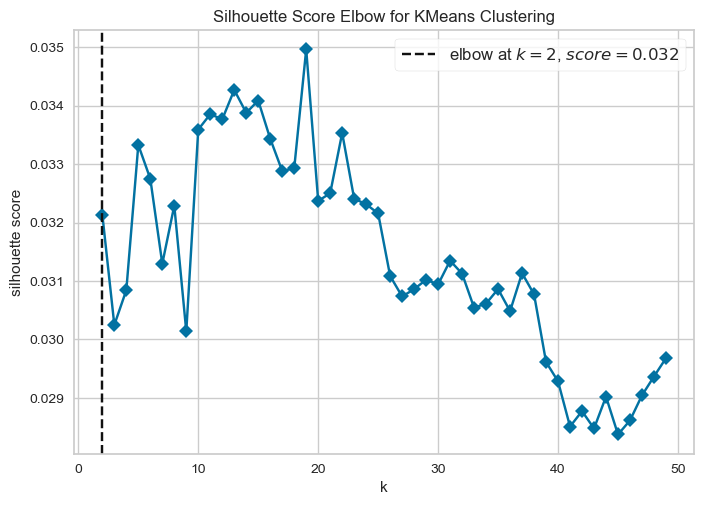

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [107]:
# appliquons sur nos données et visualisons
visualizer.fit(X_bow) # ou autre en fonction de l'embedding
visualizer.show()

In [59]:
# Clustering HDBSCAN
clusterer = HDBSCAN(min_cluster_size=15, metric='euclidean')
cluster_labels = clusterer.fit_predict(X_bert)

# Afficher nombre de clusters trouvés (hors bruit)
n_clusters = len(set(cluster_labels))
print(f"HDBSCAN a trouvé {n_clusters} clusters.")

C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN a trouvé 4 clusters.
